<div style="color:red;font-size:40px;">
<center>
<font size="6" >
به نام خدا 
<br><br>
<font size="5" color="grey" >
<b>
تحلیل لینک بر روی نیازمندی‌های صفحات گیت‌هاب‎


</b>
<br>
<font size="4" color="black">
دانشجویان:
<br>
 (98101339) سایه جارالهی 
<br>
 (98171104) بردیا محمدی 
<br>
امیررضا سلیمان‌بیگی (98109837)
<br>
استاد: دکتر احسان‌الدین عسگری
</center>
<br>
</div>

# Crawl

Note: config.py file should be in the same dir as this notebook. In this config file, only the github token should be placed. 

In [1]:
import re
import requests
import base64
import codecs
import time
import config
import csv

In [ ]:

def check_rate_limit(headers):

    url = 'https://api.github.com/rate_limit'
    response = requests.get(url, headers=headers)
    result = response.json()
    # print(result)
    for key, value_out in result.items():
        if key == 'rate' and value_out['remaining'] == 0:
            return False
        elif key == 'resources':
            for _, value_in in value_out.items():
                if value_in['remaining'] == 0:
                    return False
    return True

def get_repos_dict(headers, topic: str, stars: str = '1000'):
    url = 'https://api.github.com/search/repositories'
    params = {
        # in KB
        'q': f'stars:>={stars} is:public topic:{topic}',
        'sort': 'stars',
        'order': 'desc',
        'per_page': 100,
        'page': 1
    }

    response = requests.get(url, headers=headers, params=params)
    if response.status_code != requests.codes.ok:
        handle_error('Error in get_repos_dict', headers)
        response = requests.get(url, headers=headers, params=params)
    result = response.json()
    # print(response.url)
    repos_dict = {}
    for repo in result['items']:
        repos_dict[repo["html_url"]] = {
            "topic": topic,
            "content_url": repo["contents_url"][:-7]
        }
    return repos_dict


def save_repos_requirement(token: str):

    headers = {
        'Accept': 'application/vnd.github.v3+json',
        'Authorization': f'token {token}'
    }

    topics = [
        'django',
        'deep-learning',
        'computer-vision',
        'machine-learning'
    ]

    repos_dict = {}
    for topic in topics:
        # print(topic)
        new_repos_dict = get_repos_dict(
            headers=headers,
            topic=topic
        )
        repos_dict = {**repos_dict, **new_repos_dict}

    get_requirement(headers, repos_dict)
    save_requirements(repos_dict)


def get_requirement(headers, repos_dict):

    for repo_url, repo_dict in repos_dict.items():
        # print(repo_url)

        response = requests.get(repo_dict["content_url"], headers=headers)
        if response.status_code != requests.codes.ok:
            handle_error('Error in get_requirement', headers)
            response = requests.get(repo_dict["content_url"], headers=headers)
        content = response.json()

        requirement_url = get_requirement_url(content)
        if not requirement_url:
            continue
        else:
            print('found')
        repo_dict["content"] = get_content(headers, requirement_url)


def get_requirement_url(content):

    for item in content:
        name = item["name"]
        # print(name)
        if item["type"] == "file" and re.match(r'(requirements\.txt|requirement\.txt)', name):
            return item["url"]
    return False


def get_content(headers, url):

    response = requests.get(url, headers=headers)
    if response.status_code != requests.codes.ok:
        handle_error('Error in get_content', headers)
        response = requests.get(url, headers=headers)
    result = response.json()

    if result["encoding"] != "base64":
        print("Error, encoding is not base64, url: {url}")
        decoded_content = result["content"]
    else:
        content = base64.b64decode(result["content"])
        decoded_content = codecs.decode(content)

    return decoded_content


def handle_error(error_message: str, headers):
    print(error_message)
    while True:
        time.sleep(60)
        if check_rate_limit(headers):
            break


def save_requirements(repos_dict):
    with open('data.csv', 'w') as file:
        writer = csv.writer(file)
        writer.writerow(["url", "topic", "content"])
        for repo_url, repo_dict in repos_dict.items():
            if "content" in repo_dict:
                writer.writerow([
                    repo_url,
                    repo_dict["topic"],
                    repo_dict["content"]
                ])
    

In [ ]:
save_repos_requirement(token=config.token)

# Load data

In [2]:
import pandas as pd


In [3]:
data_df = pd.read_csv('data.csv')

# Preprocess

In [4]:
import re

In [5]:
def normalize_sent(sent):
    req = re.sub('#(.+)', '', sent)
    req = re.sub('(.*)#(.+)', '\\1', req)
    if not req or req == '#':
        return ''
    req = re.sub('([^!~=><]+)(==|>|>|<|~|!)(.*)','\\1',req.strip())
    if req.startswith('-') or req.startswith('.') or req.startswith('='):
        req = ''
    return req

def preprocess(content:str)-> str:
    splitted_content = content.split('\n')
    requirements = []
    for sent in splitted_content:
        req = normalize_sent(sent.strip())
        if not req:
            continue
        requirements.append(req)
    return ' '.join(requirements)

In [6]:
def get_processed_requirements(topic = None):
    if not topic:
        return [preprocess(req) for req in data_df['content']]
    return [preprocess(row['content']) for _, row in data_df.iterrows() if row['topic'] == topic]
    

In [7]:
print('choices for topic: ')
print(set(data_df['topic']))

choices for topic: 
{'django', 'machine-learning', 'computer-vision', 'deep-learning'}


# Link Analysis

In [8]:
requirements = get_processed_requirements()

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import networkx as nx

In [10]:
class LinkAnalyser:

    def __init__(self, alpha = 0.9):
        self.vectorizer = TfidfVectorizer(ngram_range = (1,1), stop_words = None, norm = 'l2')
        self.data = None
        self.data_df = None
        self.P = None
        self.alpha = alpha
    
    def set_data(self, data_df, data):
        self.data_df = data_df
        self.data = data
        self.vectorizer.fit_transform(data)
        X = self.vectorizer.transform(data)
        self.P = X.dot(X.T)
    
    def get_graph(self):
        P_norm = normalize(self.P)
        G = nx.from_numpy_matrix(P_norm.toarray())
        return G

    def draw_graph(self):
        nx.draw(self.get_graph())

    def page_rank(self):
        pr = nx.pagerank(self.get_graph(), alpha=self.alpha)
        return pr
    
    def hit_rank(self):
        h, a = nx.hits(self.get_graph())
        return h, a

    def get_ranked_data(self, p_dict)->list:
        res = sorted(p_dict.items(), key=lambda item: item[1], reverse =True )
        final = pd.DataFrame(columns=['url', 'topic', 'content'])
        print(len(res))
        for i, prob in res:
            url = self.data_df.iloc[i]['url']
            topic = self.data_df.iloc[i]['topic']
            final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
        return final

In [11]:
link_analyzer = LinkAnalyser()

In [12]:
link_analyzer.set_data(data=requirements,data_df = data_df)

In [13]:
page_rank = link_analyzer.page_rank()
page_rank

{0: 0.0008532423208191124,
 1: 0.008883429152659203,
 2: 0.005969771012750229,
 3: 0.005582220839120707,
 4: 0.008084669515844746,
 5: 0.005932909577109061,
 6: 0.010400505737215848,
 7: 0.009004215826503459,
 8: 0.010840162740779362,
 9: 0.0008532423208191124,
 10: 0.009245791267240736,
 11: 0.00874336771543359,
 12: 0.007032303062866296,
 13: 0.0008532423208191124,
 14: 0.009431275336445877,
 15: 0.0046310563677017785,
 16: 0.010427366150972645,
 17: 0.008674374748978413,
 18: 0.009463165637450359,
 19: 0.007779179931465132,
 20: 0.009101584938171956,
 21: 0.004066902298114031,
 22: 0.0008532423208191124,
 23: 0.007327763677265538,
 24: 0.004054532739920427,
 25: 0.006861848499294008,
 26: 0.009473618711981754,
 27: 0.00906047919891298,
 28: 0.008488555891286394,
 29: 0.00878382762153546,
 30: 0.007751711164622826,
 31: 0.007842586466711298,
 32: 0.007855048335558685,
 33: 0.011949753962174268,
 34: 0.009266590145960398,
 35: 0.008570213660896275,
 36: 0.0008532423208191124,
 37: 0.0

In [14]:
page_rank_results = link_analyzer.get_ranked_data(page_rank)
page_rank_results

128


/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/28

/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/28

/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/28

/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/28

,url,topic,content
0,https://github.com/ultralytics/yolov5,machine-learning,matplotlib numpy opencv-python Pillow PyYAML r...
1,https://github.com/davidsandberg/facenet,computer-vision,tensorflow scipy scikit-learn opencv-python h5...
2,https://github.com/ultralytics/yolov3,machine-learning,matplotlib numpy opencv-python Pillow PyYAML r...
3,https://github.com/JaidedAI/EasyOCR,machine-learning,torch torchvision opencv-python-headless scipy...
4,https://github.com/cleardusk/3DDFA,computer-vision,torch torchvision numpy scipy matplotlib dlib ...
...,...,...,...
123,https://github.com/scikit-image/scikit-image,computer-vision,
124,https://github.com/open-mmlab/mmediting,computer-vision,
125,https://github.com/victordibia/handtracking,computer-vision,
126,https://github.com/voxel51/fiftyone,computer-vision,


In [15]:
hit, auth = link_analyzer.hit_rank()

In [16]:
hub_results = link_analyzer.get_ranked_data(hit)
hub_results

128


/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/28

/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/28

/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/28

/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/28

,url,topic,content
0,https://github.com/ultralytics/yolov3,machine-learning,matplotlib numpy opencv-python Pillow PyYAML r...
1,https://github.com/ultralytics/yolov5,machine-learning,matplotlib numpy opencv-python Pillow PyYAML r...
2,https://github.com/JaidedAI/EasyOCR,machine-learning,torch torchvision opencv-python-headless scipy...
3,https://github.com/davidsandberg/facenet,computer-vision,tensorflow scipy scikit-learn opencv-python h5...
4,https://github.com/cleardusk/3DDFA,computer-vision,torch torchvision numpy scipy matplotlib dlib ...
...,...,...,...
123,https://github.com/scikit-image/scikit-image,computer-vision,
124,https://github.com/open-mmlab/mmediting,computer-vision,
125,https://github.com/victordibia/handtracking,computer-vision,
126,https://github.com/voxel51/fiftyone,computer-vision,


In [17]:
auth_results = link_analyzer.get_ranked_data(auth)
auth_results

128


/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/28

/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/28

/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/28

/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/28

,url,topic,content
0,https://github.com/ultralytics/yolov3,machine-learning,matplotlib numpy opencv-python Pillow PyYAML r...
1,https://github.com/ultralytics/yolov5,machine-learning,matplotlib numpy opencv-python Pillow PyYAML r...
2,https://github.com/JaidedAI/EasyOCR,machine-learning,torch torchvision opencv-python-headless scipy...
3,https://github.com/davidsandberg/facenet,computer-vision,tensorflow scipy scikit-learn opencv-python h5...
4,https://github.com/cleardusk/3DDFA,computer-vision,torch torchvision numpy scipy matplotlib dlib ...
...,...,...,...
123,https://github.com/scikit-image/scikit-image,computer-vision,
124,https://github.com/open-mmlab/mmediting,computer-vision,
125,https://github.com/victordibia/handtracking,computer-vision,
126,https://github.com/voxel51/fiftyone,computer-vision,


# Technical Report


<div dir = "rtl">
در این تمرین، تحلیل لینک بر اساس نیازمندی‌های فایل 
requirements.txt
در پروژه های گیتهاب انجام شده است. برای اینکار ابتدا داده ها از طریق 
api
گیتهاب کرال شده است. در گام بعدی، با انجام پیش پردازش، تنها نام کتابخانه‌هایی که در پروژه ها از آن‌ها استفاده شده است استخراج شده است. 
در گام بعدی با ساختن گراف رابطه‌های پروژه‌ها و استفاده از دو الگوریتم pagerank
و
HITS
رتبه‌دهی انجام شده است. 
</div>

<div dir = "rtl">
<font size="4" color="purple">
۱)‌ جمع آوری داده ها
<br>
<font size="3" color="black">
در این بخش مشابه با کرالینگ تمرین قبل، از api گیتهاب استفاده شده است. 
در این بخش تنها مخزن‌هایی کرال میشوند که دارای فایل 
requirements.txt
در دایرکتوری اصلی خود باشند. 
برای اینکه در نهایت جمع بندی راحتتر صورت گیرد،‌ ریپازیتوری‌ها از چهار موضوع مشخص 
انتخاب شده اند که شامل موارد زیر است
Django
,computer-vision
,machine-learning
,deep-learning

برای هر ریپازیتوری،‌ آدرس آن، موضوع و متن requirement
کرال میشود و در فایل 
data.csv
ذخیره میشود. 
</div>


<div dir = "rtl">
<font size="4" color="purple">
۲) پیش پردازش
    <br>
<font size="3" color="black">
پیش پردازش این بخش، به آسانی قابل انجام است. تنها کافی است کامنت‌های هر فایل حذف شود. تمامی این کامنتها با # شروع میشود. 
همچنین باید دستوراتی که در بین کتابخانه ها هستند نیز حذف شوند. این دستورات با - شروع می‌شوند. 

همچنین ورژن تمامی کتابخانه‌ها باید حذف شوند زیرا این ورژن‌ها ربطی به نوع ریپازیتوری و تحلیل لینک ندارند. 
</div>


<div dir = "rtl">
<font size="4" color="purple">
۳) تحلیل لینک
    <br>
<font size="3" color="black">
در این بخش ابتدا به کمک 
tf-idf
و ضرب داخلی آن در ترانهاده خودش، ماتریس P به دست آورده شد. 
توجه داریم که استفاده از 
tf-idf 
باعث میشود بین دو داکیومنت در صورتی یال باشد که کلمه مشترکی داشته باشند. در غیر این صورت ضرب داخلی بردار دو داکیومنت صفر شده و دیگر یالی در گراف آن‌ها وجود نخواهد داشت. 

پس از اینکه ماتریس P ساخته شد
،
سطرهای آن نرمالایز شد تا گراف رابطه به درستی رسم شود. پس از آن به کمک توابع آماده، این گراف که یک گراف بدون جهت است ساخته شد. 
در این گراف به ازای هر داکیومنت یک راس وجود دارد و بین دو یال درصورتی یال وجود دارد که کلمات آن‌ها(همان کتابخانه‌ها)اشتراک داشته باشد. 
همچنین یال هایی برای teleport
قرار داده شده تا درصورتی که در یک راس قرار گرفتیم، احتمالی برای رفتن به تمامی راس های دیگر نیز وجود داشته باشد. 

پس از آن با استفاده از دو الگوریتم pagerank
 و HITS
 خروجی های نهایی به دست آورده شد. 

 
</div>


<div dir = "rtl">
<font size="4" color="red">
الف) 
HITS
    <br>
<font size="3" color="black">
نکته قابل توجه در این است که خروجی هر دو رنکینگ برحسب 
h
و a
برابر است .همانطور که قبلا گفته شده بود، یال های گراف دو طرفه است و درنتجه هر نودی که یالهای بیشتری داشته باشد،‌هم hub
بالاتری دارد و هم 
auth بالاتر. در نتیجه مقادیر خروجی برای هر دو h
و
a
در رنکینگ مطابق زیر برابر خواهدبود
</div>


In [18]:
list(auth_results['url']) == list(hub_results['url'])

True

In [19]:
pd.options.display.max_colwidth = 300

<div dir = "rtl">
10 خروجی اول:
</div>

In [20]:
auth_results.head(10)

,url,topic,content
0,https://github.com/ultralytics/yolov3,machine-learning,matplotlib numpy opencv-python Pillow PyYAML requests scipy torch torchvision tqdm tensorboard wandb pandas seaborn thop
1,https://github.com/ultralytics/yolov5,machine-learning,matplotlib numpy opencv-python Pillow PyYAML requests scipy torch torchvision tqdm protobuf tensorboard pandas seaborn ipython psutil thop
2,https://github.com/JaidedAI/EasyOCR,machine-learning,torch torchvision opencv-python-headless scipy numpy Pillow scikit-image python-bidi PyYAML
3,https://github.com/davidsandberg/facenet,computer-vision,tensorflow scipy scikit-learn opencv-python h5py matplotlib Pillow requests psutil
4,https://github.com/cleardusk/3DDFA,computer-vision,torch torchvision numpy scipy matplotlib dlib opencv-python
5,https://github.com/jacobgil/pytorch-grad-cam,deep-learning,numpy Pillow torch torchvision ttach tqdm opencv-python
6,https://github.com/milesial/Pytorch-UNet,deep-learning,matplotlib numpy Pillow torch torchvision tqdm wandb
7,https://github.com/foolwood/SiamMask,computer-vision,Cython colorama numpy requests fire torch matplotlib numba scipy h5py pandas tqdm tensorboardX opencv_python torch torchvision
8,https://github.com/tianzhi0549/FCOS,computer-vision,torch torchvision ninja yacs cython matplotlib tqdm opencv-python scikit-image
9,https://github.com/wkentaro/pytorch-fcn,computer-vision,fcn numpy Pillow pytz scipy torch torchvision tqdm


<div dir = "rtl">
10 خروجی آخر:
</div>

In [23]:
auth_results.tail(10)

,url,topic,content
118,https://github.com/axnsan12/drf-yasg,django,
119,https://github.com/allegro/ralph,django,
120,https://github.com/mozilla/pontoon,django,
121,https://github.com/Lightning-AI/lightning,machine-learning,
122,https://github.com/jina-ai/jina,machine-learning,
123,https://github.com/scikit-image/scikit-image,computer-vision,
124,https://github.com/open-mmlab/mmediting,computer-vision,
125,https://github.com/victordibia/handtracking,computer-vision,
126,https://github.com/voxel51/fiftyone,computer-vision,
127,https://github.com/gnes-ai/gnes,computer-vision,


<div dir = "rtl">
همانطور که در دو خانه بالا مشهود است، راس هایی که احتمال قرار گرفتن در آن‌ها از بقیه کمتر است، راس‌هایی هستند که در requirement آن ها کتابخانه ای موجود نبوده است
(توجه داریم که این فایل خالی نبوده که در دیتاست قرار نگیرد،‌)
در حالی که آن repository هایی که با احتمال بیشتر در آن ها قرار میگیریم، همانطور که در دیتافریم نیز مشخص است، کتابخانه های اصلی مربوط به تاپیک‌ها را دارند. 
برای مثال torch, torchvision, numpy, pandas
کتابخانه های بسیار رایجی هستند و در این رنکینگ نیز در ابتدا قرار میگیرند. 
</div>

<div dir = "rtl">
حال این رنکینگ را تنها بر روی داده هایی انجام می دهیم که از سرچ 
django
به دست آمده اند و خروجی را تحلیل میکنیم. 

</div>

In [24]:
d = get_processed_requirements('django')
link_analyzer.set_data(data=d,data_df =data_df.loc[data_df['topic'] == 'django'])
hit, auth = link_analyzer.hit_rank()
hub_results = link_analyzer.get_ranked_data(hit)
hub_results.head(10)

37


/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/28

,url,topic,content
0,https://github.com/viewflow/django-fsm,django,django
1,https://github.com/wger-project/wger,django,bleach django-bootstrap-breadcrumbs django-formtools django-recaptcha Django django-crispy-forms django_compressor django_extensions django-storages django-environ easy-thumbnails icalendar invoke pillow reportlab requests django-cors-headers django-filter djangorestframework django-sortedm2m
2,https://github.com/arguman/arguman.org,django,Django Unidecode django-social-auth httplib2 oauth2 python-openid wsgiref django-gravatar2 django-extensions markdown2 pymongo django-markitup Markdown djangorestframework django-filter django-redis redis requests nltk textblob anora snowballstemmer django-typogrify networkx psycopg2
3,https://github.com/alanjds/drf-nested-routers,django,Django djangorestframework
4,https://github.com/babybuddy/babybuddy,django,asgiref boto3 botocore defusedxml diff-match-patch dj-database-url django django-appconf django-axes django-filter django-imagekit django-import-export django-ipware django-storages django-taggit django-widget-tweaks djangorestframework et-xmlfile faker gunicorn jmespath markuppy odfpy openpyxl ...
5,https://github.com/githublitao/api_automation_test,django,certifi Django django-cors-headers djangorestframework idna pytz requests django-rest-swagger python-docx django-crispy-forms django-formtools django-import-export django-reversion python-crontab PyMySQL XlsxWriter PyMySQL python-docx pypinyin uWSGI
6,https://github.com/pinry/pinry,django,certifi charset-normalizer coreapi coreschema django-appconf django-braces django-compressor django-filter django-taggit django djangorestframework gunicorn idna itypes jinja2 markdown markupsafe mock pillow psycopg2-binary pytz rcssmin requests rjsmin sqlparse uritemplate urllib3
7,https://github.com/wsvincent/djangox,django,Django django-allauth django-crispy-forms django-debug-toolbar whitenoise psycopg2-binary
8,https://github.com/LibrePhotos/librephotos,django,Django django-constance django-cors-headers django-chunked-upload django-cryptography django-extensions django-filter django-picklefield django-redis django-rq django-bulk-update django-silk djangorestframework djangorestframework-simplejwt drf-extensions drf-spectacular face-recognition Flask F...
9,https://github.com/photonixapp/photonix,django,numpy scipy matplotlib tensorflow opencv-python annoy Django django-cors-headers django-filter PyJWT django-graphql-jwt graphene graphene-django Markdown Pillow inotify asyncinotify python-dateutil pytz pyshp requests python-redis-lock redis psycopg2-binary gunicorn pytest pytest-django mock fac...


<div dir = "rtl">
<br><br>
همانطور که در خروجی قابل مشاهده است، منظقی است که کتابخانه 
django
اولین راس باشد. همچنین تمامی راس های بعدی نیز دارای django هستند و 

همچنین در انتها نیز راس هایی هستند که فایل نیازمندی آن ها خالی است. 

توجه داریم که در ابتدا که تمامی repository های مربوط به ۴ فیلد مختلف را یکجا تبدیل به گراف کردیم، آن repository هایی که در کل داده ها، تاپیک آن ها تعداد بیشتری داشت در ابتدای لیست قرار گرفتند. 
</div>

<div dir = "rtl">
در شکل زیر گراف مربوط به صفحات django را مشاهده می‌کنید.
</div>

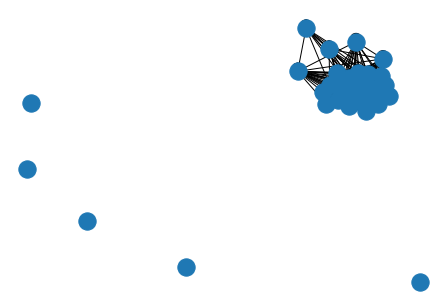

In [25]:
link_analyzer.draw_graph()

<div dir = "rtl">
<font size="4" color="red">
ب)
PageRank
    <br>
<font size="3" color="black">
در این بخش نیز با همان گراف بدون جهت اولیه، کار را ادامه میدهیم. الگوریتم PageRank برای گراف های جهت دار طراحی شده است اما این الگوریتم بررسی نمی کند که آیا گراف ورودی جهت دار است یا خیر و با تبدیل هر یال در گراف جهت دار به دو یال بر روی گراف های بدون جهت اجرا می شود.
با استفاده از روش power iteration بردار ویژه ماتریس P محاسبه می شود. محاسبه بردار ویژه تضمینی برای همگرایی ندارد و اگر تعداد iteration های از ماکسیمم تعریف شده بیشتر باشد exception raise می شود.
در نهایت احتمالی که با استفاده از الگوریتم PageRank بدست آمده است به عنوان PageRank value به ازای هر نود گراف قرار میدهیم.
</div>

In [26]:
link_analyzer.set_data(data=requirements,data_df = data_df)
page_rank = link_analyzer.page_rank()
page_rank_results = link_analyzer.get_ranked_data(page_rank)

128


/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/28

/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/28

/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/28

/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/28

<div dir = "rtl">
10 خروجی اول:
</div>

In [27]:
page_rank_results.head(10)

,url,topic,content
0,https://github.com/ultralytics/yolov5,machine-learning,matplotlib numpy opencv-python Pillow PyYAML requests scipy torch torchvision tqdm protobuf tensorboard pandas seaborn ipython psutil thop
1,https://github.com/davidsandberg/facenet,computer-vision,tensorflow scipy scikit-learn opencv-python h5py matplotlib Pillow requests psutil
2,https://github.com/ultralytics/yolov3,machine-learning,matplotlib numpy opencv-python Pillow PyYAML requests scipy torch torchvision tqdm tensorboard wandb pandas seaborn thop
3,https://github.com/JaidedAI/EasyOCR,machine-learning,torch torchvision opencv-python-headless scipy numpy Pillow scikit-image python-bidi PyYAML
4,https://github.com/cleardusk/3DDFA,computer-vision,torch torchvision numpy scipy matplotlib dlib opencv-python
5,https://github.com/photonixapp/photonix,django,numpy scipy matplotlib tensorflow opencv-python annoy Django django-cors-headers django-filter PyJWT django-graphql-jwt graphene graphene-django Markdown Pillow inotify asyncinotify python-dateutil pytz pyshp requests python-redis-lock redis psycopg2-binary gunicorn pytest pytest-django mock fac...
6,https://github.com/jacobgil/pytorch-grad-cam,deep-learning,numpy Pillow torch torchvision ttach tqdm opencv-python
7,https://github.com/milesial/Pytorch-UNet,deep-learning,matplotlib numpy Pillow torch torchvision tqdm wandb
8,https://github.com/foolwood/SiamMask,computer-vision,Cython colorama numpy requests fire torch matplotlib numba scipy h5py pandas tqdm tensorboardX opencv_python torch torchvision
9,https://github.com/wkentaro/pytorch-fcn,computer-vision,fcn numpy Pillow pytz scipy torch torchvision tqdm


<div dir = "rtl">
10 خروجی آخر:
</div>

In [28]:
page_rank_results.tail(10)

,url,topic,content
118,https://github.com/axnsan12/drf-yasg,django,
119,https://github.com/allegro/ralph,django,
120,https://github.com/mozilla/pontoon,django,
121,https://github.com/Lightning-AI/lightning,machine-learning,
122,https://github.com/jina-ai/jina,machine-learning,
123,https://github.com/scikit-image/scikit-image,computer-vision,
124,https://github.com/open-mmlab/mmediting,computer-vision,
125,https://github.com/victordibia/handtracking,computer-vision,
126,https://github.com/voxel51/fiftyone,computer-vision,
127,https://github.com/gnes-ai/gnes,computer-vision,


<div dir = "rtl">
همانطور که در دو خانه بالا مشهود است، راس‌هایی که احتمال قرار گرفتن در آن‌ها از بقیه کمتر است، راس‌هایی هستند که در requirement آن‌ها کتابخانه ای موجود نبوده است
(توجه داریم که این فایل خالی نبوده که در دیتاست قرار نگیرد)
در حالی که آن repository هایی که با احتمال بیشتر در آن ها قرار میگیریم، همانطور که در دیتافریم نیز مشخص است، کتابخانه های اصلی مربوط به تاپیک‌ها را دارند. 
برای مثال torch, torchvision, numpy, pandas, django
کتابخانه های بسیار رایجی هستند و در این رنکینگ نیز در ابتدا قرار میگیرند. 
</div>

<div dir = "rtl">
در این قسمت از pagerank برای بدست‌ آوردن بهترین رنکینگ داده‌هایی استفاده می‌کنیم که کوئری آنها machine-learning بوده است.
</div>

In [29]:
topic_data = get_processed_requirements('machine-learning')
link_analyzer.set_data(data=topic_data, data_df=data_df.loc[data_df['topic'] == 'machine-learning'])
page_rank = link_analyzer.page_rank()
page_rank_results = link_analyzer.get_ranked_data(page_rank)
page_rank_results

32


/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/2865049780.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append({'url': url, 'topic':topic, 'content':self.data[i]}, ignore_index=True)
/var/folders/20/39xftvjd67d7x2ykjzb972b40000gn/T/ipykernel_80367/28

,url,topic,content
0,https://github.com/ultralytics/yolov5,machine-learning,matplotlib numpy opencv-python Pillow PyYAML requests scipy torch torchvision tqdm protobuf tensorboard pandas seaborn ipython psutil thop
1,https://github.com/ultralytics/yolov3,machine-learning,matplotlib numpy opencv-python Pillow PyYAML requests scipy torch torchvision tqdm tensorboard wandb pandas seaborn thop
2,https://github.com/JaidedAI/EasyOCR,machine-learning,torch torchvision opencv-python-headless scipy numpy Pillow scikit-image python-bidi PyYAML
3,https://github.com/rushter/MLAlgorithms,machine-learning,tqdm matplotlib numpy scikit-learn scipy seaborn autograd gym
4,https://github.com/ddbourgin/numpy-ml,machine-learning,numpy scipy
5,https://github.com/Hironsan/BossSensor,machine-learning,h5py Keras mock numpy pbr protobuf PyYAML scikit-learn scipy six sklearn tensorflow Theano
6,https://github.com/lmcinnes/umap,machine-learning,numpy scipy scikit-learn numba pynndescent tbb tqdm
7,https://github.com/OlafenwaMoses/ImageAI,machine-learning,tensorflow keras numpy pillow scipy h5py matplotlib opencv-python keras-resnet
8,https://github.com/ludwig-ai/ludwig,machine-learning,Cython h5py numpy pandas scipy tabulate scikit-learn tqdm torch torchaudio torchtext torchvision transformers spacy PyYAML absl-py kaggle requests tables fsspec[http] dataclasses-json jsonschema marshmallow marshmallow-jsonschema marshmallow-dataclass tensorboard torchmetrics torchinfo filelock ...
9,https://github.com/snorkel-team/snorkel,machine-learning,numpy scipy pandas tqdm scikit-learn torch munkres networkx tensorboard spacy blis dask[dataframe] distributed dill black flake8 isort mypy pydocstyle pytest pytest-cov pytest-doctestplus tox


<div dir = "rtl">
همانطور که مشاهده می‌کنید،‌ در نتایج اول کتابخانه‌های torch، torchvision و numpy حضور دارند و این کتابخانه‌ها به ندرت در نتایج آخر حضور دارند. با توجه به مرتبط بودن این کتابخانه‌ها به machine-learning، به این نتیجه می‌رسیم که نتایج خوب هستند.
</div>

<div dir = "rtl">
در شکل زیر گراف مربوط به صفحات machine-learning را مشاهده می‌کنید.
</div>

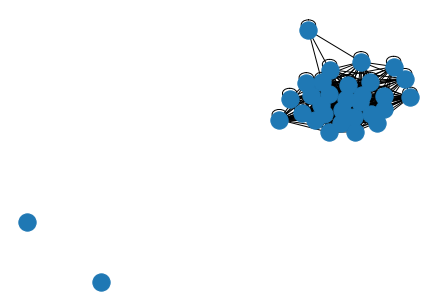

In [30]:
link_analyzer.draw_graph()